# T1 - Aprendizado de Máquina

Este arquivo contém o código, bem como as explicações necessárias, para o T1 da disciplina de Aprendizado de Máquina, compreendendo as etapas de download do dataset escolhido, pré-processamento dos dados, treinamento dos modelos de **kNN, Naïve Bayes e Árvores de Decisão** e, por fim, suas avaliações, interpretações e comparações.

## Download do dataset

O dataset escolhido para a tarefa de classificação possui dados sobre características físico-químicas da água e classifica as amostras em potável (rótulo 1) ou não-potável (rótulo 0). Nesta seção, fazemos o download do dataset do Kaggle e o convertemos para um objeto `pandas.DataFrame`.

In [4]:
import kagglehub as kh
import pandas    as pd
import os

dataset_path = kh.dataset_download("uom190346a/water-quality-and-potability")
dataset_file = "water_potability.csv"

dataset_abs_path = os.path.join(dataset_path, dataset_file)

df = pd.read_csv(dataset_abs_path)
print(df.head())
print("Shape:", df.shape)

         ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0       NaN  204.890455  20791.318981     7.300212  368.516441    564.308654   
1  3.716080  129.422921  18630.057858     6.635246         NaN    592.885359   
2  8.099124  224.236259  19909.541732     9.275884         NaN    418.606213   
3  8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
4  9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       10.379783        86.990970   2.963135           0  
1       15.180013        56.329076   4.500656           0  
2       16.868637        66.420093   3.055934           0  
3       18.436524       100.341674   4.628771           0  
4       11.558279        31.997993   4.075075           0  
Shape: (3276, 10)


## Pré-processamento

Para o pré-processamento, serão aplicados:
1. Tratamento de valores ausentes (NaNs) preenchendo-os com a mediana da coluna;
2. Verificação de outliers e padronização dos dados (para o kNN);
3. Separação de atributos (features) e rótulos (labels).

Não será realizada a separação em conjuntos de treino e teste pois será utilizada **validação cruzada**.

Valores NaN (pré-tratamento):
ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64


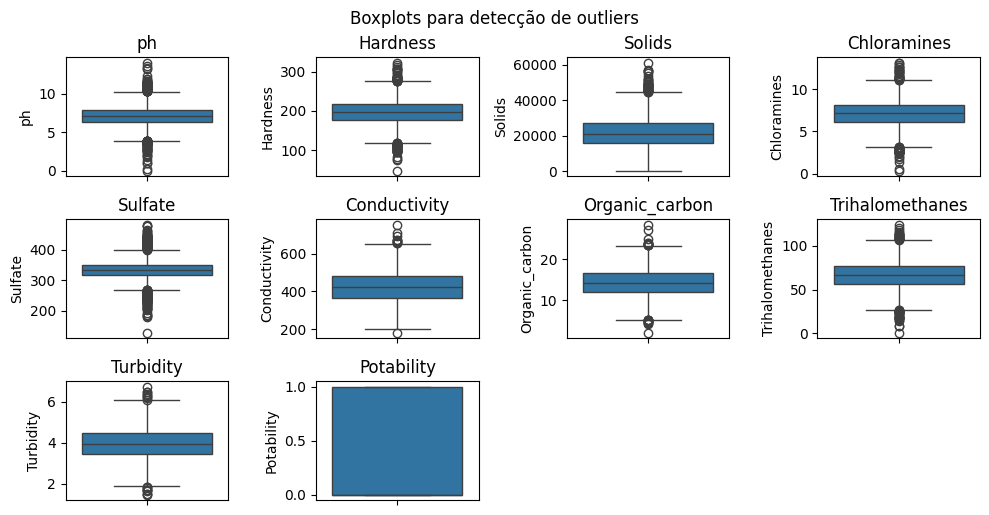

Dataset tratado:
            ph  Hardness   Solids  Chloramines  Sulfate  Conductivity  \
count  3276.00   3276.00  3276.00      3276.00  3276.00       3276.00   
mean      0.00      0.00    -0.00         0.00    -0.00          0.00   
std       1.00      1.00     1.00         1.00     1.00          1.00   
min      -4.81     -4.53    -2.47        -4.28    -5.66         -3.03   
25%      -0.54     -0.59    -0.72        -0.63    -0.46         -0.75   
50%      -0.03      0.02    -0.12         0.01    -0.01         -0.05   
75%       0.54      0.62     0.61         0.63     0.46          0.69   
max       4.71      3.86     4.47         3.79     4.08          4.05   

       Organic_carbon  Trihalomethanes  Turbidity  
count         3276.00          3276.00    3276.00  
mean             0.00            -0.00       0.00  
std              1.00             1.00       1.00  
min             -3.65            -4.16      -3.23  
25%             -0.67            -0.62      -0.68  
50%          

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

print("Valores NaN (pré-tratamento):")
print(df.isna().sum())
df['ph'] = df['ph'].fillna(df['ph'].median())
df['Sulfate'] = df['Sulfate'].fillna(df['Sulfate'].median())
df['Trihalomethanes'] = df['Trihalomethanes'].fillna(df['Trihalomethanes'].median())

numeric_columns = df.select_dtypes(include='number').columns
plt.figure(figsize=(10, 5))
for i, col in enumerate(numeric_columns):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(data=df, y=col)
    plt.title(col)
    plt.tight_layout()
plt.suptitle("Boxplots para detecção de outliers", y=1.02)
plt.show()

X = df.drop(columns=['Potability'])
y = df['Potability']

# Padronizacao devido aos outliers para o kNN
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

print("Dataset tratado:")
print(X.describe().round(2))

## Treinamento dos modelos (com validação cruzada)

Nesta seção é feito o treinamento dos modelos utilizando o método de grid search para encontrar os parâmetros que produzem os melhores valores de acurácia.

### Árvore de Decisão

In [ ]:
#################################### TUNING ####################################

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    'max_depth': [None, 5, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 5, 10],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best'],
    'class_weight': [None, 'balanced'],
    'max_features': [None, 'sqrt', 'log2'],
    'ccp_alpha': [0.0, 0.0001, 0.001, 0.005],
}

kf = StratifiedKFold(n_splits=3, shuffle=False)
dt_grid = GridSearchCV(
    DecisionTreeClassifier(),
    param_grid,
    cv=kf,
    scoring='accuracy',
    n_jobs=-1
)
dt_grid.fit(X, y)

print("Best grid score (DT):", dt_grid.best_score_)
print("Best grid params (DT):", dt_grid.best_params_)

In [19]:
#################################### TREINAMENTO (OU CARREGAMENTO) DO MODELO ####################################

import joblib
import os
from sklearn.tree import DecisionTreeClassifier

DT_MODEL_PATH = os.path.join("models", "dt-model.joblib")

if not os.path.exists(DT_MODEL_PATH):
    dt = DecisionTreeClassifier(
        ccp_alpha=0.0001,
        class_weight=None,
        criterion='gini',
        max_depth=5,
        max_features='log2',
        min_samples_leaf=1,
        min_samples_split=10,
        splitter='best'
    )
    dt.fit(X, y)
    joblib.dump(dt, DT_MODEL_PATH)

dt_model = joblib.load(DT_MODEL_PATH)

### kNN

In [ ]:
#################################### TUNING ####################################

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 15, 21, 27],
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski', 'cosine'],
    'p': [1, 2], # 1=Manhattan, 2=Euclidean (only used when metric='minkowski')
}

kf = StratifiedKFold(n_splits=3, shuffle=False)
knn_grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    cv=kf,
    scoring='accuracy',
    n_jobs=-1
)
knn_grid.fit(X, y)

print("Best score (kNN):", knn_grid.best_score_)
print("Best params (kNN):", knn_grid.best_params_)

In [22]:
#################################### TREINAMENTO (OU CARREGAMENTO) DO MODELO ####################################

import joblib
import os
from sklearn.neighbors import KNeighborsClassifier

KNN_MODEL_PATH = os.path.join("models", "knn-model.joblib")

if not os.path.exists(KNN_MODEL_PATH):
    knn = KNeighborsClassifier(
        metric='minkowski',
        n_neighbors=21,
        p=2,
        weights='distance'
    )
    knn.fit(X, y)
    joblib.dump(knn, KNN_MODEL_PATH)

knn_model = joblib.load(KNN_MODEL_PATH)

### Naïve Bayes

In [ ]:
#################################### TUNING ####################################

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import numpy as np

param_grid = {
    'var_smoothing': np.logspace(-11, -7, 3)
}

kf = StratifiedKFold(n_splits=3, shuffle=True)
nb_grid = GridSearchCV(
    estimator=GaussianNB(),
    param_grid=param_grid,
    cv=kf,
    scoring='accuracy',
    n_jobs=-1
)
nb_grid.fit(X, y)

print("Best accuracy (NB):", nb_grid.best_score_)
print("Best params (NB):", nb_grid.best_params_)

In [1]:
#################################### TREINAMENTO (OU CARREGAMENTO) DO MODELO ####################################

import joblib
import os
from sklearn.naive_bayes import GaussianNB
import numpy as np

NB_MODEL_PATH = os.path.join("models", "nb-model.joblib")

if not os.path.exists(NB_MODEL_PATH):
    nb = GaussianNB(var_smoothing=1e-11)
    nb.fit(X, y)
    joblib.dump(nb, NB_MODEL_PATH)

nb_model = joblib.load(NB_MODEL_PATH)

## Interpretação dos modelos

### Árvore de Decisão

Para a interpretação da Árvore de Decisão gerada, será analizado o **SHAP summary** das features e, então, será verificado como as observações feitas nesse gráfico se refletem na representação visual da árvore. É importante ressaltar que o SHAP já ordena as features em ordem decrescente, de cima para baixo, baseado na importância que aquela feature tem para as decisões feitas pelo modelo.

Algumas observações pertinentes com relação à forma como o modelo interpreta as features do dataset:

Com relação ao **SHAP summary**:
- **Dureza e Sulfatos**: São as features mais importantes. Valores baixos tendem a puxar as predições para a classe positiva (1), enquanto valores altos por si só tendem a não ser tão conclusivos para o modelo. A dureza possui alguns outliers com alto valor e que tiveram forte influência para predizer a classe positiva.
- **pH**: De um modo geral, valores baixos (ácidos) tendem a puxar as predições do modelo para a classe negativa (0), mas também podem influenciar até um certo limite na predição para a classe positiva. O mesmo vale para valores altos de pH, mas estes tendem a ter um impacto menos significativo nas predições.
- **Sólidos**: Tendem a contribuir para as predições, mas com impactos mais variados com relação aos seus valores absolutos. Há uma sobreposição mais significativa entre os diferentes valores assumidos pela feature e os SHAP values considerados, indicando que essa feature pode ter uma maior dependência com os valores de outras para definir o resultado da classificação.
- **Cloraminas**: É visível que, quando esses valores contribuem para uma predição a favor da classe positiva (1), são baixos. Há uma leve tendência, também, a classificar valores altos como favoráveis à classe negativa (0).
- **Carbonos Orgânicos, Trialometanos, Turbidez e Condutividade**: De um modo geral, apresentam um padrão semelhante no SHAP summary, mas não são considerados muito relevantes pelo modelo. Nos poucos casos em que apresentam alguma contribuição para a predição, seus altos valores tendem a influenciar a classificação para a classe negativa (0).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#################################### SHAP ####################################
import shap

shap.initjs()

explainer = shap.TreeExplainer(dt_model)
shap_values = explainer.shap_values(X)

#for class_idx in range(shap_values.shape[2]):
#    print(f"SHAP summary plot for class {class_idx}:")
#    plt.figure()
#    shap.summary_plot(shap_values[:, :, class_idx], X, feature_names=X.columns)

# Plotamos apenas a classe 0, ja que eh um problema de classificacao binaria
print(f"SHAP summary plot for class 1 (POTABLE):")
plt.figure()
shap.summary_plot(shap_values[:, :, 1], X, feature_names=X.columns)

#################################### DT ####################################
from sklearn.tree import plot_tree

print("Generated decision tree:")
plt.figure(figsize=(30, 15))
plot_tree(
    dt_model,
    feature_names=X.columns,
    class_names=np.unique(y).astype(str),
    filled=True,
    proportion=True,
    precision=2
)
plt.show()

### kNN

Esta análise do SHAP obtido a partir do modelo **knn_model**, com o intuito de compreender o impacto de cada variável nas decisões de classificação sobre a potabilidade da água.

O gráfico analisado é um *summary plot* com estilo *layered violin*, que permite visualizar tanto a importância quanto a direção do impacto de cada variável.

#### Como ler o gráfico

- O **valor SHAP** indica quanto cada variável contribui para o modelo prever uma determinada classe:
  - Valores **positivos** puxam para a classe 1 **Potable**
  - Valores **negativos** puxam para a classe 0 **Non-Potable**

- As **cores** representam o valor da feature:
  - **vermelho**: valores altos da feature
  - **azul**: valores baixos da feature

- A **ordem vertical** das variáveis define sua importância no modelo. As features no topo do gráfico são as mais influentes para a decisão de classificação.

#### SHAP summary

- *Solids* e *pH* apresentaram um impacto negativo. A maioria das amostras para essas variáveis contribuiu para reduzir a probabilidade de a amostra ser classificada como classe 1.

- *Sulfate*, *Chloramines* e *Trihalomethanes* mostraram padrões de impacto mais complexos. Nessas features os valores elevados tendem a contribuir para a classificação como classe 1, entretanto baixos tambem indicam para classe 1, demonstrando ser mais contextual.

- *Hardness*, *Conductivity*, *Turbidity* e *Organic_carbon* demonstraram impacto global mais negativo no modelo, com distribuições de valores SHAP abaixo de zero, observa-se uma tendência de que valores mais altos em *Turbidity* e *Hardness* influenciem negativamente a predição da classe 1.



Using 150 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 100/100 [04:48<00:00,  2.89s/it]


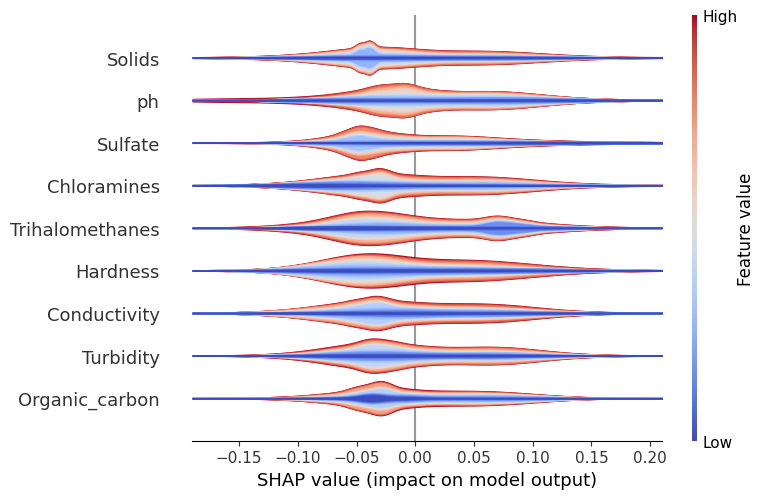

In [5]:
import shap
from lime.lime_tabular import LimeTabularExplainer
import numpy as np
import matplotlib.pyplot as plt



#################################### SHAP ####################################
shap.initjs()

X_background = shap.sample(X,150) #ammount to use

explainer = shap.KernelExplainer(knn_model.predict_proba, X_background)
shap_values = explainer.shap_values(X_background.iloc[:100]) #100 iterations, takes 9 to 10 minutes with X = 300
figure=plt.figure()
shap.summary_plot(shap_values[:,: ,1], X_background.iloc[:100], feature_names=X.columns, plot_type="layered_violin")


### Naïve Bayes

Este gráfico representa uma análise de interpretabilidade baseada em **SHAP values** aplicada ao modelo **nb_model**

O gráfico mostra a **média dos valores absolutos de SHAP** para cada feature, separados por classe:
- **Barras sólidas** indicam contribuições para a classe 0 **Non Potable**
- **Barras hachuradas** representam contribuições para a classe 1 **Potable**

- *Sulfate* é a variável mais impactante, especialmente nas predições da classe 1(Potable). O valor médio do SHAP nesta classe foi bem superior ao da classe 0 (Non Potable).

- *Hardness* apresentou impacto relevante, com contribuições positivas. O modelo considera esse atributo de forma significativa na distinção entre classe 0 e 1, favorecendo a classe 1.

- *pH* e *Solids* têm influência intermediária, com contribuição equilibrada entre as classes.

- *Chloramines* teve uma influência maior, fazendo a predição para classe 1.

- *Organic_carbon*, *Conductivity**, *Trihalomethanes* e *Turbidity* mostraram impacto marginal. O modelo atribui baixa importância média a esses atributos.


In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt


##################################### SHAP ####################################
shap.initjs()

# X_background=shap.sample(X,1700) #ammount to use, tolerable time to use, 6 to 7 minutes
# explainer=shap.KernelExplainer(nb_model.predict_proba, X_background)
# shap_values = explainer.shap_values(X_background)

# figure=plt.figure()
# shap.summary_plot(shap_values[:,: ,1], X_background, feature_names=X.columns,plot_type="bar")

predict_lab = nb_model.predict_proba(X)
pl= np.argmax(predict_lab, axis=1)
explainer = shap.Explainer(nb_model.predict_proba, X)
shap_values = explainer(X)
pot=["Potable" if i == 1 else "Non Potable" for i in pl]
shap.plots.bar(shap_values[..., 1].cohorts(pot).abs.mean(0))
